In [90]:
!pip install pandas scikit-learn matplotlib seaborn plotly tensorflow

In [126]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Nome das colunas com base em adult.names
column_names = [
    "age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
    "occupation", "relationship", "race", "sex", "capital_gain", "capital_loss",
    "hours_per_week", "native_country", "income"
]

# Carregamento dos Dados
base_censo = pd.read_csv('data/adult.data', names=column_names, sep=", ", engine='python')
print("Distribuição das classes antes do balanceamento:")
print(base_censo['income'].value_counts())



Distribuição das classes antes do balanceamento:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64


In [135]:
# Separação de Características - Features (X) e Alvo (Target - y)
X_censo = base_censo.iloc[:, 0:14].values
y_censo = base_censo.iloc[:, 14].values

# Codificação das Variáveis Categóricas com Label Encoding
label_encoder_workclass = LabelEncoder()
label_encoder_education = LabelEncoder()
label_encoder_marital = LabelEncoder()
label_encoder_occupation = LabelEncoder()
label_encoder_relationship = LabelEncoder()
label_encoder_race = LabelEncoder()
label_encoder_sex = LabelEncoder()
label_encoder_country = LabelEncoder()

X_censo[:,1] = label_encoder_workclass.fit_transform(X_censo[:,1])
X_censo[:,3] = label_encoder_education.fit_transform(X_censo[:,3])
X_censo[:,5] = label_encoder_marital.fit_transform(X_censo[:,5])
X_censo[:,6] = label_encoder_occupation.fit_transform(X_censo[:,6])
X_censo[:,7] = label_encoder_relationship.fit_transform(X_censo[:,7])
X_censo[:,8] = label_encoder_race.fit_transform(X_censo[:,8])
X_censo[:,9] = label_encoder_sex.fit_transform(X_censo[:,9])
X_censo[:,13] = label_encoder_country.fit_transform(X_censo[:,13])




In [136]:
# Codificação com OneHot Encoding
onehotencoder_censo = ColumnTransformer(
    transformers=[('OneHot', OneHotEncoder(), [1,3,5,6,7,8,9,13])],
    remainder='passthrough'
)
X_censo = onehotencoder_censo.fit_transform(X_censo).toarray()



In [137]:
# Balanceamento dos Dados
X_50k = X_censo[y_censo == '<=50K']
y_50k = y_censo[y_censo == '<=50K']
X_mais_50k = X_censo[y_censo == '>50K']
y_mais_50k = y_censo[y_censo == '>50K']

# Amostragem de treinamento com 15% para <=50K e 40% para >50K
X_treinamento_50k, y_treinamento_50k = resample(X_50k, y_50k, replace=False, n_samples=max(int(0.15 * len(y_50k)), 1), random_state=0)
X_treinamento_mais_50k, y_treinamento_mais_50k = resample(X_mais_50k, y_mais_50k, replace=False, n_samples=max(int(0.40 * len(y_mais_50k)), 1), random_state=0)

# Conjunto de teste com o restante
X_teste_50k, y_teste_50k = resample(X_50k, y_50k, replace=False, n_samples=len(y_50k) - len(y_treinamento_50k), random_state=0)
X_teste_mais_50k, y_teste_mais_50k = resample(X_mais_50k, y_mais_50k, replace=False, n_samples=len(y_mais_50k) - len(y_treinamento_mais_50k), random_state=0)

# Combinar conjuntos balanceados
X_censo_treinamento = np.vstack((X_treinamento_50k, X_treinamento_mais_50k))
y_censo_treinamento = np.hstack((y_treinamento_50k, y_treinamento_mais_50k))
X_teste_final = np.vstack((X_teste_50k, X_teste_mais_50k))
y_teste_final = np.hstack((y_teste_50k, y_teste_mais_50k))

# Convertendo a variável alvo para binária
y_censo_treinamento = np.where(y_censo_treinamento == '>50K', 1, 0)
y_teste_final = np.where(y_teste_final == '>50K', 1, 0)



In [138]:
# Normalização dos Dados
scaler = StandardScaler()
X_censo_treinamento = scaler.fit_transform(X_censo_treinamento)
X_teste_final = scaler.transform(X_teste_final)

In [139]:
# Construção do Modelo de Rede Neural com TensorFlow
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_censo_treinamento.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') 
])

# Rodar o Modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



/Users/lailson/Documents/projetos/census/env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [141]:
# Treinamento do Modelo
history = model.fit(X_censo_treinamento, y_censo_treinamento, epochs=200, batch_size=32, validation_split=0.2)

# Avaliação do Modelo
y_pred_proba = model.predict(X_teste_final)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()
acuracia_final = accuracy_score(y_teste_final, y_pred)
print("\nAcurácia do modelo com o conjunto de teste ajustado:", acuracia_final)



Epoch 1/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.9290 - loss: 0.1667 - val_accuracy: 0.7129 - val_loss: 0.9779
Epoch 2/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9251 - loss: 0.1673 - val_accuracy: 0.7056 - val_loss: 1.0074
Epoch 3/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.9219 - loss: 0.1727 - val_accuracy: 0.6749 - val_loss: 1.1152
Epoch 4/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.9258 - loss: 0.1641 - val_accuracy: 0.7268 - val_loss: 0.9484
Epoch 5/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.9225 - loss: 0.1669 - val_accuracy: 0.7421 - val_loss: 0.8917
Epoch 6/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.9269 - loss: 0.1618 - val_accuracy: 0.7159 - val_loss: 1.0276
Epoch 7/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.9320 - loss: 0.1542 - val_accuracy: 0.6647 - val_loss: 1.1418
Epoch 8/200
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.9393 - loss: 0.1

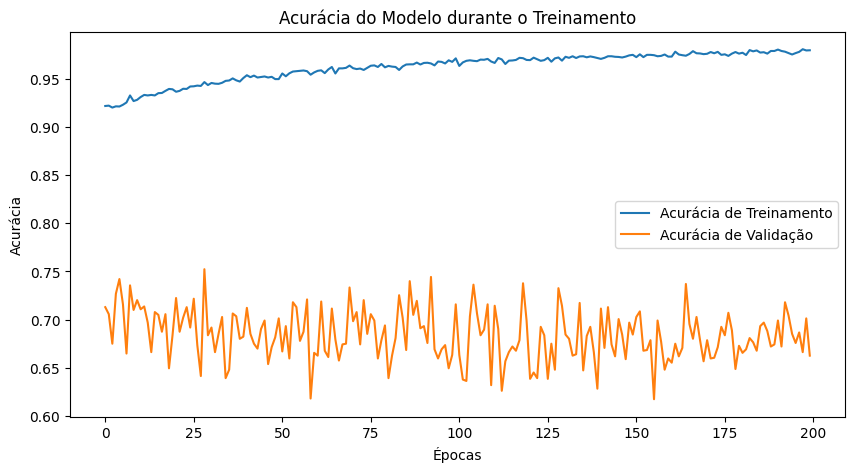

In [144]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia do Modelo durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()


Matriz de Confusão:
[[18487  2525]
 [ 1058  3647]]


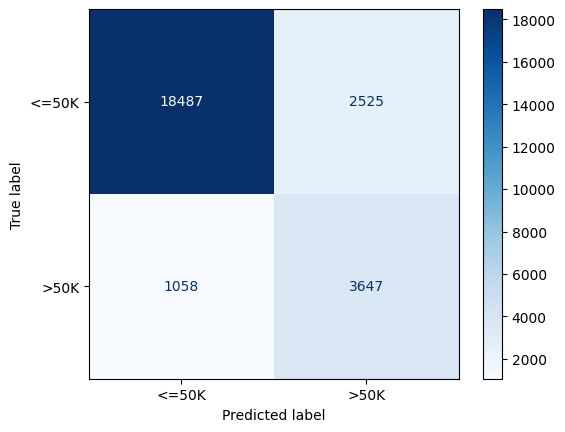


Relatório de Classificação:
              precision    recall  f1-score   support

       <=50K       0.95      0.88      0.91     21012
        >50K       0.59      0.78      0.67      4705

    accuracy                           0.86     25717
   macro avg       0.77      0.83      0.79     25717
weighted avg       0.88      0.86      0.87     25717



In [143]:
# Exibição da Matriz de Confusão
matriz_confusao_final = confusion_matrix(y_teste_final, y_pred)
print("\nMatriz de Confusão:")
print(matriz_confusao_final)

# Exibindo a matriz de confusão de forma gráfica
disp_final = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao_final, display_labels=['<=50K', '>50K'])
disp_final.plot(cmap="Blues")
plt.show()

# Relatório de Classificação com foco na classe >50K
relatorio_classificacao_final = classification_report(y_teste_final, y_pred, target_names=['<=50K', '>50K'])
print("\nRelatório de Classificação:")
print(relatorio_classificacao_final)

In [ ]:
# MLClassifier

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [102]:
base_censo = pd.read_csv('data/adult.data', names=column_names, sep=", ", engine='python')
print("Distribuição das classes antes do balanceamento:")
print(base_censo['income'].value_counts())

Distribuição das classes antes do balanceamento:
income
<=50K    24720
>50K      7841
Name: count, dtype: int64


In [103]:
X_censo = base_censo.iloc[:, 0:14].values
y_censo = base_censo.iloc[:, 14].values

In [104]:
label_encoder_workclass = LabelEncoder()
label_encoder_education = LabelEncoder()
label_encoder_marital = LabelEncoder()
label_encoder_occupation = LabelEncoder()
label_encoder_relationship = LabelEncoder()
label_encoder_race = LabelEncoder()
label_encoder_sex = LabelEncoder()
label_encoder_country = LabelEncoder()

X_censo[:,1] = label_encoder_workclass.fit_transform(X_censo[:,1])
X_censo[:,3] = label_encoder_education.fit_transform(X_censo[:,3])
X_censo[:,5] = label_encoder_marital.fit_transform(X_censo[:,5])
X_censo[:,6] = label_encoder_occupation.fit_transform(X_censo[:,6])
X_censo[:,7] = label_encoder_relationship.fit_transform(X_censo[:,7])
X_censo[:,8] = label_encoder_race.fit_transform(X_censo[:,8])
X_censo[:,9] = label_encoder_sex.fit_transform(X_censo[:,9])
X_censo[:,13] = label_encoder_country.fit_transform(X_censo[:,13])

In [105]:
onehotencoder_censo = ColumnTransformer(
    transformers=[('OneHot', OneHotEncoder(), [1,3,5,6,7,8,9,13])],
    remainder='passthrough'
)
X_censo = onehotencoder_censo.fit_transform(X_censo).toarray()

In [106]:
X_50k = X_censo[y_censo == '<=50K']
y_50k = y_censo[y_censo == '<=50K']
X_mais_50k = X_censo[y_censo == '>50K']
y_mais_50k = y_censo[y_censo == '>50K']

# Garantir que o tamanho da amostra seja ao menos 1
sample_size_50k = max(min(int(0.30 * len(y_50k)), len(y_50k)), 1)
sample_size_mais_50k = max(min(int(0.30 * len(y_mais_50k)), len(y_mais_50k)), 1)

# Resampling com tamanho ajustado
X_treinamento_50k, y_treinamento_50k = resample(X_50k, y_50k, replace=False, n_samples=sample_size_50k, random_state=0)
X_treinamento_mais_50k, y_treinamento_mais_50k = resample(X_mais_50k, y_mais_50k, replace=False, n_samples=sample_size_mais_50k, random_state=0)

# Conjunto de teste balanceado
X_teste_50k, y_teste_50k = resample(X_50k, y_50k, replace=False, n_samples=max(5500, 1), random_state=0)
X_teste_mais_50k, y_teste_mais_50k = resample(X_mais_50k, y_mais_50k, replace=False, n_samples=max(2500, 1), random_state=0)

# Combinar conjuntos balanceados
X_censo_treinamento = np.vstack((X_treinamento_50k, X_treinamento_mais_50k))
y_censo_treinamento = np.hstack((y_treinamento_50k, y_treinamento_mais_50k))
X_teste_final = np.vstack((X_teste_50k, X_teste_mais_50k))
y_teste_final = np.hstack((y_teste_50k, y_teste_mais_50k))

In [107]:
sample_size_50k

7416

In [79]:
sample_size_mais_50k

2352

In [109]:
#Normalização dos dados
scaler = StandardScaler()
X_censo_treinamento = scaler.fit_transform(X_censo_treinamento)
X_teste_final = scaler.transform(X_teste_final)

In [117]:
# Configuração do Modelo de Rede Neural
mlp_classifier = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)


In [118]:
# Treinamento do Modelo
mlp_classifier.fit(X_censo_treinamento, y_censo_treinamento)

/Users/lailson/Documents/projetos/census/env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)

In [120]:
# Avaliação do Modelo
previsoes_final = mlp_classifier.predict(X_teste_final)
acuracia_final = accuracy_score(y_teste_final, previsoes_final)
print("Acurácia do modelo MLP com o conjunto de teste ajustado:", acuracia_final)


Acurácia do modelo MLP com o conjunto de teste ajustado: 0.961125


In [122]:
# Exibição da Matriz de Confusão
matriz_confusao_final = confusion_matrix(y_teste_final, previsoes_final)
print("Matriz de Confusão:")
print(matriz_confusao_final)

Matriz de Confusão:
[[5403   97]
 [ 214 2286]]


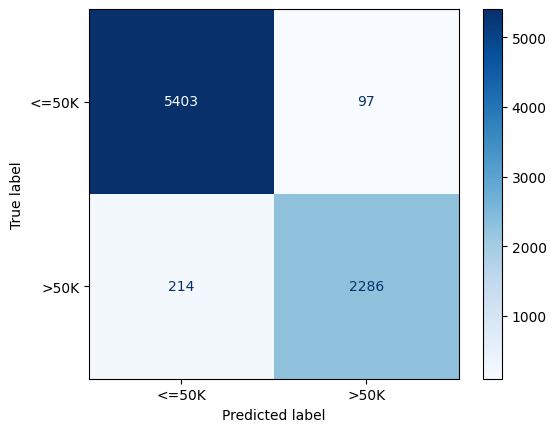

In [123]:
disp_final = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao_final, display_labels=mlp_classifier.classes_)
disp_final.plot(cmap="Blues")
plt.show()

In [124]:
#Relatório de Classificação
relatorio_classificacao_final = classification_report(y_teste_final, previsoes_final, target_names=['<=50K', '>50K'])
print("Relatório de Classificação:")
print(relatorio_classificacao_final)

Relatório de Classificação:
              precision    recall  f1-score   support

       <=50K       0.96      0.98      0.97      5500
        >50K       0.96      0.91      0.94      2500

    accuracy                           0.96      8000
   macro avg       0.96      0.95      0.95      8000
weighted avg       0.96      0.96      0.96      8000

